In [1]:
!nvidia-smi

Sun Sep  8 01:13:31 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1080        Off | 00000000:01:00.0  On |                  N/A |
| 28%   59C    P0              48W / 200W |    122MiB /  8192MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import pandas as pd
import numpy as np

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
%matplotlib inline
import matplotlib.pyplot as plt

In [44]:
import joblib
import sklearn
import catboost

In [45]:
print(pd.__version__)
print(joblib.__version__)
print(sklearn.__version__)
print(catboost.__version__)

2.1.3
1.2.0
1.3.2
1.2


In [4]:
#import torch
#from transformers import TrainingArguments, Trainer
#from transformers import BertTokenizer, BertForSequenceClassification
#from transformers import AutoTokenizer, AutoModel
#device = torch.device("cpu")

In [6]:
#from datasets import Dataset, DatasetDict, load_metric
#from transformers import EvalPrediction

In [5]:
import re
from tqdm.notebook import tqdm
tqdm.pandas()

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier

In [65]:
from nltk import sent_tokenize, word_tokenize, regexp_tokenize
#nltk.download('stopwords') 
import nltk
import spacy

stopwords_nltk = nltk.corpus.stopwords.words('russian') #лист русский стоп-слов 
stopwords_nltk_en = nltk.corpus.stopwords.words('english') 
stopwords_nltk.extend(stopwords_nltk_en) #если есть текста на английском

new_stop = ["обязанность", "должностной", "работать", "инструкция", "работа", "согласно", "должность"]
stopwords_nltk.extend(new_stop) 

lemmatizer = spacy.load('ru_core_news_md', disable = ['parser', 'ner'])

In [53]:
#очистка текста
def full_clean(text):
    '''подготовка текста к подаче в модель для каждого текста (через applay)'''
    try:
        text=re.sub(r"[^a-zA-Zа-яА-ЯёЁ0-9#]", " ", text)
        text = text.lower()
        text = re.sub(" +", " ", text).strip() #оставляем только 1 пробел
    except:
        text = ' '
    #токены для моделей
    tokens = [token.lemma_ for token in lemmatizer(text) if token.lemma_ not in stopwords_nltk]
    #для tfidf на вход текст
    text = " ".join(tokens)
    return text, tokens


def preprocess_text(df):
    '''подготовка текста к подаче в модель колонкой'''
    new_corpus=[]
    new_tokens=[]

    for text in tqdm(df):
        text, tokens = full_clean(text)
        new_corpus.append(text)
        new_tokens.append(tokens)
        
    return new_corpus, new_tokens

In [8]:
def tfidf_fit(train=None, test=None, tfidf=True, ngram_range=(1, 1), max_features=1000, save=False):
    #на вход текст
    #min_df : игнорируются термины, частота употребления которых строго ниже заданного порога.
    #max_df : игнорируются термины, частота которых строго превышает заданный порог
    if test:
        data = pd.concat([train, test])
    else:
        data = train
    if tfidf:        
        model = TfidfVectorizer(ngram_range=(1, 1), max_features=max_features, analyzer='word', #max_df = 0.9,
                            lowercase = False, sublinear_tf=True)
    else:
        model = CountVectorizer(max_features=max_features) 
    #тренировка
    model.fit(data)
    #feature_names = model.get_feature_names_out()
    
    #сохранение натренированной модели для приложения
    if save:
        joblib.dump(model, 'tfidf.pkl') 
        
    return model
    
def tfidf_embeding(model=None, df=None):   
    '''Преобразование текста в мешок слов'''
    if model==None:
        #загрузить если нет
        model = joblib.load('tfidf.pkl')
    else:
        model=model
    X = model.transform(df)
    #feature_names = model.get_feature_names_out()
    #X = pd.DataFrame(model.toarray(), columns = feature_names, index = df.index)
    
    return X.toarray()#.tolist()


In [9]:
def validation(name, model, X_valid, y_valid, report=True, importances=True):
    class_names=pd.Series(y_valid).value_counts().index.tolist()
    if name == "catc":
        #model.set_probability_threshold(0.495)
        model_valid = model.predict(X_valid)
        model_valid_ = model.predict_proba(X_valid)[:, 1]
        #model_valid = (model.predict_proba(valid[features])[:, 1]>= threshold).astype(int)
    elif name == "lgbc":
        model_valid = model.predict(X_valid)
        model_valid_ = model.predict_proba(X_valid)[:, 1]
    elif name == "logit":
        model_valid = model.predict(X_valid)
        model_valid_ = model.predict_proba(X_valid)[:, 1]
    #расчет метрики
    print("f1_weight: ", f1_score(y_valid, model_valid, average='weighted'))
    #print("roc_auc: ", roc_auc_score(y_valid, model_valid_, average='weighted', multi_class="ovr"))  #'macro'
    
    if report==True:
        print("Отчет о классификации: ")
        print(classification_report(y_valid, model_valid, zero_division=0, labels=class_names))

    if importances==True:
        fig, ax = plt.subplots(figsize=(8, 6))
        if name == "catc":
            #влияющие факторы
            fea_imp = pd.DataFrame({'imp': model.feature_importances_, 'col': feature_names})
            fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-20:]
            #fea_imp.plot(kind='barh', x='col', y='imp', figsize=(8, 6), legend=None)
            ax.barh(fea_imp['col'], fea_imp['imp'], align='center')
        
        elif name == "lgbc":
            #model.plot_importance(lgbc, max_num_features=20, height=0.8, ax=ax)
            fea_imp = pd.DataFrame({'imp': model.feature_importances_, 'col': feature_names})
            fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-20:]
            #fea_imp.plot(kind='barh', x='col', y='imp', figsize=(8, 6), legend=None)
            ax.barh(fea_imp['col'], fea_imp['imp'], align='center')
        elif name == "logit":
            #logit.coef_ среднее по всем классам
            fea_imp = pd.DataFrame({'imp': np.mean(logit.coef_, axis=0), 'col': feature_names})
            fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-20:]
            ax.barh(fea_imp['col'], fea_imp['imp'], align='center')
        
        plt.title('Важность признаков для модели')   
        plt.ylabel('Признаки')
        plt.xlabel('Важность')

In [10]:
#df_job_list = pd.read_csv('vprod_train/JOB_LIST.csv',  sep=',', engine='python', encoding='Windows-1251')
#with open('vprod_train/JOB_LIST.csv', encoding ='utf-8', errors='ignore') as f:
#    df_job_list = f.read().split('\n')
#df_job_list

### Профессии

In [11]:
all_filenames=['vprod_train/TRAIN_RES_1.csv', 'vprod_train/TRAIN_RES_2.csv', 'vprod_train/TRAIN_RES_3.csv',
              'vprod_train/TRAIN_RES_4.csv', 'vprod_train/TRAIN_RES_5.csv'
              ]
df_TRAIN_RES = pd.concat([pd.read_csv(f) for f in all_filenames], ignore_index=True)

In [12]:
df_TRAIN_RES

,achievements,achievements_modified,company_name,demands,id_cv,job_title
0,NaN,NaN,Управление социальной защиты населения Сердобс...,"Работала,непосредственно, с федеральными льгот...",52860148-26da-11e8-a184-9122a281f90e,инспектор
1,NaN,NaN,Администрация города Сердобска,Работа с реестром муниципальной собственности,52860148-26da-11e8-a184-9122a281f90e,инспектор
2,"Работы не закончены, т.к. нет настоящего желан...","Работы не закончены, т.к. нет настоящего желан...",январь 2016-настоящее времяООО «АРТЕЛЬ СТАРАТЕ...,Курирую работы по рудному направлению: соавтор...,e3c857b0-26a0-11e7-bcca-736ab11edb0c,геолог
3,NaN,NaN,"ОАО «Васильевский рудник», п.Мотыгино, Красноя...",ГРП. Документация керна разведочных скважин,e3c857b0-26a0-11e7-bcca-736ab11edb0c,геолог
4,NaN,NaN,"ООО «Артель старателей «ТАЛ»», Усть-Нера, Респ...",Поисково-разведочные работы на месторождении р...,e3c857b0-26a0-11e7-bcca-736ab11edb0c,геолог
...,...,...,...,...,...,...
9287460,Создал работоспособную команду| Увеличил объем...,Создал работоспособную команду| Увеличил объем...,РУСБИЗНЕСАВТО,Общение с клиентами по вопросам ремонта и обсл...,3386f2f0-263e-11e8-94aa-736ab11edb0c,руководитель
9287461,За период работы увеличен объем производства к...,За период работы увеличен объем производства к...,"ООО ""Москва на Дону""",Руководство финансово-хозяйственной деятельнос...,8cc2102c-fd0d-11e7-a659-e37b4be0b9ed,директор
9287462,И меются публикации в российских изданиях,И меются публикации в российских изданиях,ФБУН ФНЦ Медико-профилактических технологий уп...,"Пробоподготовка, иммуноферментый анализ, владе...",bbdbb110-f94b-11e7-b311-736ab11edb0c,иммунолог
9287463,Самостоятельно внедрила методы количественного...,Самостоятельно внедрила методы количественного...,"ГБУЗ ПК ""КДКБ"" Медико-генетическая консультация",Лабораторная диагностика (проведение пренаталь...,bbdbb110-f94b-11e7-b311-736ab11edb0c,биолог


In [13]:
df_TRAIN_RES['job_title'].value_counts()

job_title
специалист                          846134
менеджер                            762736
бухгалтер                           504850
инженер                             405754
оператор                            367872
                                     ...  
навойщик основы из проволоки             1
обмазчик ковшей                          1
графитировщик                            1
помощник заместителя губернатора         1
классификаторщик шлифпорошков            1
Name: count, Length: 1921, dtype: int64

In [14]:
train = df_TRAIN_RES[['demands', 'job_title']].copy().dropna()
#train = train[train['job_title'].isin(top_job)].dropna()

In [15]:
top_job = list(train['job_title'].value_counts().index[train['job_title'].value_counts() >500])
len(top_job)

433

In [66]:
# выборка для каждого класса
sample_train=pd.DataFrame()
for j in tqdm(top_job):
    try:
        temp = train[train['job_title']==j].sample(n=500, random_state=42)
    except:
        temp = train[train['job_title']==j]
    sample_train = pd.concat([sample_train, temp], ignore_index=True)

  0%|          | 0/433 [00:00<?, ?it/s]

In [67]:
sample_train

,demands,job_title
0,"документооборот, Word, Excell, консультация кл...",специалист
1,"Организаций отдыха детей-сирот и детей, оставш...",специалист
2,"Ведение клиентской базы, продажа, предоставлен...",специалист
3,Работа с первичными документами| Подшивка архи...,специалист
4,- Заключение договоров на ремонтно-строительны...,специалист
...,...,...
229652,глажка и комплектование белья,гладильщик
229653,глажка белья,гладильщик
229654,Глажка белья,гладильщик
229655,-Глажение и отпаривние прямого и фасонного бел...,гладильщик


In [68]:
df_val = train.sample(n=4000, random_state=42)

Подготовка текста tf-idf

In [69]:
sample_train['text_clean'], sample_train['tokens']=preprocess_text(sample_train['demands'])

  0%|          | 0/229657 [00:00<?, ?it/s]

In [70]:
tfidf = tfidf_fit(train=sample_train['text_clean'], tfidf=True, max_features=1500)
feature_names = tfidf.get_feature_names_out()
len(feature_names)

1500

In [71]:
feature_names

array(['01', '02', '03', ..., 'юрисдикция', 'являться', 'язык'],
      dtype=object)

In [72]:
#```Сохранение результатов TfidfVectorizer для веб-приложения
joblib.dump(tfidf, 'tfidf.pkl') 
#Загрузка
#tfidf = joblib.load('tfidf.pkl')``` 

['tfidf.pkl']

In [73]:
tfidf_embed = tfidf_embeding(model=tfidf, df=sample_train['text_clean'])

In [74]:
X_train_part, X_valid, y_train_part, y_valid = train_test_split(tfidf_embed, 
                                                                sample_train['job_title'].tolist(), 
                                                                stratify = sample_train['job_title'],
                                                                random_state=44, test_size=0.2)

In [75]:
#"liblinear" => "ovr" 
#"multinomial" => newton-cg, sag, saga и lbfgs
logit = LogisticRegression(solver = "liblinear", C=1.0, class_weight="balanced", max_iter=200, multi_class="ovr")
logit.fit(X_train_part, y_train_part)

LogisticRegression(class_weight='balanced', max_iter=200, multi_class='ovr',
                   solver='liblinear')

f1_weight:  0.4766590443653429
Отчет о классификации: 
                                                                           precision    recall  f1-score   support

                                                           электросварщик       0.90      0.70      0.79      2732
                                                              обжигальщик       0.60      0.41      0.49       100
                                                              верстальщик       0.65      0.76      0.70       100
                                         рабочий на геофизических работах       0.36      0.48      0.41       100
                                                                 каменщик       0.70      0.40      0.51       100
                                                                плиточник       0.67      0.42      0.52       100
                                                                   сторож       0.38      0.23      0.29       100
                        

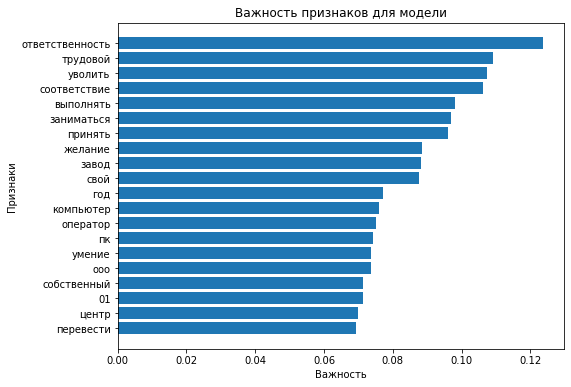

In [76]:
validation('logit', logit, X_valid, y_valid)

Отложенная выборка

In [77]:
df_val['text_clean'], df_val['tokens']=preprocess_text(df_val['demands'])

  0%|          | 0/4000 [00:00<?, ?it/s]

In [78]:
tfidf_val = tfidf_embeding(model=tfidf, df=df_val['text_clean'])

f1_weight:  0.28908964059049547
Отчет о классификации: 
                                                 precision    recall  f1-score   support

                                     специалист       0.70      0.02      0.04       369
                                       менеджер       0.69      0.11      0.19       302
                                      бухгалтер       0.83      0.59      0.69       212
                                        инженер       0.71      0.06      0.11       171
                                       водитель       0.92      0.52      0.66       147
                                       продавец       0.72      0.39      0.51       137
                                       оператор       0.39      0.08      0.14       131
                                       директор       0.50      0.11      0.18       102
                                    заместитель       0.50      0.03      0.06        96
                                         мастер      

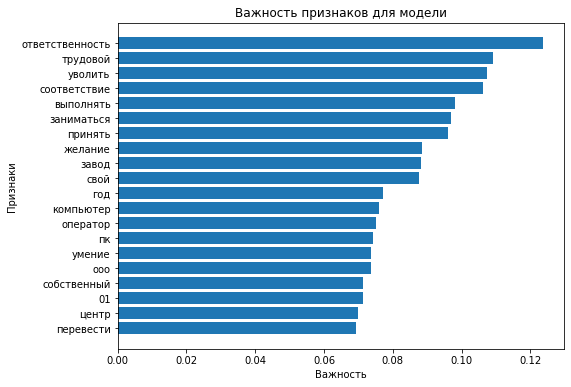

In [79]:
validation('logit', logit, tfidf_val, df_val['job_title'].tolist())

In [80]:
model_test = logit.predict(X_valid)

In [81]:
model_test

array(['сушильщик', 'вожатый', 'горничная', ..., 'электросварщик',
       'токарь', 'дознаватель'], dtype='<U73')

In [82]:
#```Сохранение результатов TfidfVectorizer для веб-приложения
joblib.dump(logit, 'logit.pkl') 
#Загрузка
#logit = joblib.load('logit.pkl')``` 

['logit.pkl']

Предсказание

In [48]:
tfidf = joblib.load('tfidf.pkl')
logit = joblib.load('logit.pkl')

In [50]:
df_test_RES = pd.read_csv('vprod_train/TRAIN_RES_1.csv')
df_test_RES

,achievements,achievements_modified,company_name,demands,id_cv,job_title
0,NaN,NaN,Управление социальной защиты населения Сердобс...,"Работала,непосредственно, с федеральными льгот...",52860148-26da-11e8-a184-9122a281f90e,инспектор
1,NaN,NaN,Администрация города Сердобска,Работа с реестром муниципальной собственности,52860148-26da-11e8-a184-9122a281f90e,инспектор
2,"Работы не закончены, т.к. нет настоящего желан...","Работы не закончены, т.к. нет настоящего желан...",январь 2016-настоящее времяООО «АРТЕЛЬ СТАРАТЕ...,Курирую работы по рудному направлению: соавтор...,e3c857b0-26a0-11e7-bcca-736ab11edb0c,геолог
3,NaN,NaN,"ОАО «Васильевский рудник», п.Мотыгино, Красноя...",ГРП. Документация керна разведочных скважин,e3c857b0-26a0-11e7-bcca-736ab11edb0c,геолог
4,NaN,NaN,"ООО «Артель старателей «ТАЛ»», Усть-Нера, Респ...",Поисково-разведочные работы на месторождении р...,e3c857b0-26a0-11e7-bcca-736ab11edb0c,геолог
...,...,...,...,...,...,...
1999995,Мое резюме на hh.ru:https://hh.ru/resume/134eb...,Мое резюме на hh.ru:https://hh.ru/resume/134eb...,Текта Групп,Мое резюме на hh.ru:https://hh.ru/resume/134eb...,0c919cc0-7e59-11ea-ba8b-ef76bd2a03c1,менеджер
1999996,NaN,NaN,"ООО""Роста""",Сортировка заказов,653b46e0-8521-11ea-9fd7-b905beff6f7a,сортировщик
1999997,NaN,NaN,ООО ВансладРитейл,Планировать и контролировать выполнение заказо...,d2925930-84cd-11ea-80d4-79a78a7da306,диспетчер
1999998,NaN,NaN,"ООО ""Агроторг""",Продажи алкогольной продукции. Контроль дебито...,631171a0-7f45-11ea-a3e6-037acc02728d,представитель


In [51]:
df_test_RES = df_test_RES.rename(columns = {"id_cv" : "id"})

In [55]:
#только для примера
#df_test_RES = df_test_RES[["id", 'demands']].sample(n=4000, random_state=1)

In [56]:
df_test_RES['text_clean'], df_test_RES['tokens']=preprocess_text(df_test_RES['demands'])

  0%|          | 0/4000 [00:00<?, ?it/s]

In [57]:
tfidf_test = tfidf_embeding(model=tfidf, df=df_test_RES['text_clean'])

In [58]:
model_test = logit.predict(tfidf_test)

In [59]:
def create_submission_part(test_df, name_of_predict_column, value):
    submission = pd.DataFrame([])
    submission['id'] = test_df['id']
    submission[name_of_predict_column] = value
    return submission

In [62]:
submission_RES_part = create_submission_part(df_test_RES, 'job_title', model_test)

In [64]:
submission_RES_part.to_csv('submission_RES_part.csv', index = False)

### берт

Кастомная метрика для модели

In [26]:
def multi_label_metrics(predictions, labels, threshold=0.5):
    # first, apply sigmoid on predictions which are of shape (batch_size, num_labels)
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    # next, use threshold to turn them into integer predictions
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    # finally, compute metrics
    y_true = labels
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    roc_auc = roc_auc_score(y_true, y_pred, average = 'micro')
    accuracy = accuracy_score(y_true, y_pred)
    # return as dictionary
    metrics = {'f1': f1_micro_average,
               'roc_auc': roc_auc,
               'accuracy': accuracy}
    return metrics

def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, 
            tuple) else p.predictions
    result = multi_label_metrics(
        predictions=preds, 
        labels=p.label_ids)
    return result

In [27]:
#перевод профессий в названия колонок для берта
data = pd.get_dummies(sample_train, columns=['job_title'], prefix='', prefix_sep='', dtype=bool, drop_first= False)
data.head()

,demands,автомаляр,автомеханик,автослесарь,автоэлектрик,агент,агент по снабжению,агроном,адвокат,администратор,...,электромонтер,электромонтёр,электроник,электросварщик,электрослесарь,энергетик,ювелир,юрисконсульт,юрист,юристконсульт
0,"документооборот, Word, Excell, консультация кл...",False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,"Организаций отдыха детей-сирот и детей, оставш...",False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,"Ведение клиентской базы, продажа, предоставлен...",False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,Работа с первичными документами| Подшивка архи...,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,- Заключение договоров на ремонтно-строительны...,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


<Axes: >

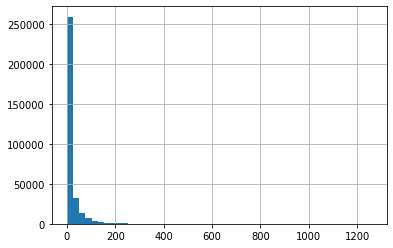

In [28]:
seq_len = [len(str(i).split()) for i in data['demands']]
pd.Series(seq_len).hist(bins = 50)

In [29]:
# словари для перевода лейблов в числа для модели
labels = [label for label in data.columns if label not in ['demands', 'text_clean', 'tokens']]
id2label = {idx:label for idx, label in enumerate(labels)}
label2id = {label:idx for idx, label in enumerate(labels)}

#из длины текста
max_length=32

#для трейна
def preprocess_data(examples):
    # take a batch of texts
    text = examples['demands']
    # encode them
    encoding = tokenizer(text, padding="max_length", truncation=True, max_length=max_length) 
    
    # add labels
    labels_batch = {k: examples[k] for k in examples.keys() if k in labels}
    # create numpy array of shape (batch_size, num_labels)
    labels_matrix = np.zeros((len(text), len(labels)))
    # fill numpy array
    for idx, label in enumerate(labels):
        labels_matrix[:, idx] = labels_batch[label]

    encoding["labels"] = labels_matrix.tolist()
  
    return encoding

def encoding_dataset(df_train, test_size=0.2):
    #подготовка датасета для модели
    #features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels']
    train_df, valid_df = train_test_split(df_train, test_size=test_size, random_state=42)
    train_dataset = Dataset.from_pandas(train_df)
    valid_dataset = Dataset.from_pandas(valid_df)
    dataset = DatasetDict({"train":train_dataset,
                                    "validation":valid_dataset,
                                    #'test': test_dataset
                                   })
    
    encoded_dataset = dataset.map(preprocess_data, batched=True, remove_columns=dataset['train'].column_names)
    encoded_dataset.set_format("torch")
    
    return encoded_dataset

In [31]:
tokenizer = AutoTokenizer.from_pretrained('d0rj/ruRoberta-distilled')

In [32]:
encoded_dataset = encoding_dataset(data, test_size=0.2)

  0%|          | 0/259 [00:00<?, ?ba/s]

  0%|          | 0/65 [00:00<?, ?ba/s]

In [33]:
#пример для проверки
i=0
example = encoded_dataset['train'][i]
print(example.keys())
print(example['labels'])
print([id2label[idx] for idx, label in enumerate(example['labels']) if label == 1.0])
print(tokenizer.decode(example['input_ids']))

dict_keys(['input_ids', 'attention_mask', 'labels'])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [38]:
# русский берт
#tokenizer = AutoTokenizer.from_pretrained('ai-forever/ru-en-RoSBERTa')
#model = AutoModel.from_pretrained('ai-forever/ru-en-RoSBERTa')

#tokenizer = BertTokenizer.from_pretrained('ai-forever/ruBert-large')

#tokenizer = AutoTokenizer.from_pretrained('ai-forever/ruRoberta-large')

tokenizer = BertTokenizer.from_pretrained('DeepPavlov/rubert-base-cased-sentence')
model = BertForSequenceClassification.from_pretrained('DeepPavlov/rubert-base-cased-sentence',
                                  #'training/results/checkpoint-112410',
                                  problem_type="multi_label_classification", 
                                  num_labels=len(labels),
                                  id2label=id2label,
                                  label2id=label2id, 
                                  output_hidden_states=False, 
                                  output_attentions=False).to(device)

#resize the dictionary size of the embedding layer 
model.resize_token_embeddings(len(tokenizer))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased-sentence and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Embedding(119547, 768, padding_idx=0)

In [39]:
batch_size = 2  #больше 2 ухудшают результат до случайного
metric_name = "f1"

args = TrainingArguments(
    output_dir = "training/results",        #Выходной каталог
    evaluation_strategy = "epoch",          #Валидация после каждой эпохи (можно после конкретного кол-ва шагов)
    save_strategy = "epoch",                #Сохранение после каждой эпохи
    learning_rate=1e-5,                     #Скорость обучения 1e-5 = 0,00001 
    per_device_train_batch_size=batch_size, #Размер пакета для каждого устройства во время обучения
    per_device_eval_batch_size=batch_size,  #Размер пакета для каждого устройства во время валидации
    num_train_epochs=5,                     #Кол-во эпох для обучения
    weight_decay=0.01,                      #Понижение весов
    load_best_model_at_end=True,            #Загружать ли лучшую модель после обучения
    metric_for_best_model=metric_name,
    save_total_limit = 1,
    seed=42,
    #no_cuda=True,                          #cpu
    #logging_dir = 'training/logs',         #Каталог для хранения журналов
    #logging_strategy = 'epoch',            #Логирование после каждой эпохи
    #push_to_hub=False,
    report_to="none"                        #wandb отключить
)

In [40]:
trainer = Trainer(
    model,
    args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)


In [ ]:
trainer.train()